In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np


N = 1000

u1 = np.random.normal(size=N)
u2 = np.random.normal(size=N)

x = np.random.binomial(1, p=1. / (1. + np.exp(-u1 + u2)))
y = np.random.normal(2.*x + u1 + u2)

df = pd.DataFrame({'X': x, 'Y': y, 'U1': u1, 'U2': u2})

##What is a good back-door set, $Z$, for the effect of $X$ on $Y$? Check the support of $P(X, Z)$ to see whether you can apply matching here.

$Z = \{U1, U2\}$ is a good back-door set. The back-door paths are causal forks.

## Check the support of the data

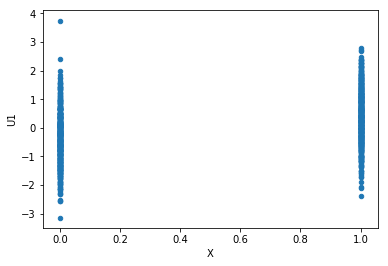

In [5]:
# here, Z = {U} satisfies the back-door criterion

df.plot(x='X', y='U1', kind='scatter')

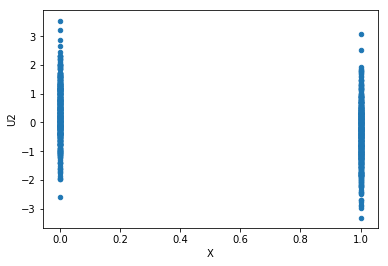

In [6]:
df.plot(x='X', y='U2', kind='scatter')

Looks good! For each $X$, $U1$ and $U2$ takes on all values in the support of $P(U1)$ and $P(U2)$. There may be a little loss of overlap in the tails, but this is a region where $P(Z)$ is quite small, so we're not too worried about it.

## Reading directly from the data-generating process, what is the average treatment effect, $\delta$, of $X$ on $Y$?

X is a direct cause of $Y$. The ATE is $\delta = 2$.

## Let's use PSM!

In [7]:
from causality.estimation.parametric import PropensityScoreMatching

matcher = PropensityScoreMatching()
matcher.estimate_ATE(df, 'X', 'Y', {'U1': 'c', 
                                    'U2': 'c'})

Optimization terminated successfully.
         Current function value: 0.526654
         Iterations 6


/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1.9502894332383902

Hard to say if it matches. Better bootstrap!

In [8]:
samples = 30

estimates = []
for _ in range(samples):
    replicate = df.sample(len(df), replace=True)
    estimates.append(matcher.estimate_ATE(replicate, 'X', 'Y', {'U1': 'c', 'U2': 'c'}))
estimates = pd.Series(estimates)

Optimization terminated successfully.
         Current function value: 0.546652
         Iterations 6


/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Optimization terminated successfully.
         Current function value: 0.527957
         Iterations 6


/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Optimization terminated successfully.
         Current function value: 0.526458
         Iterations 6


/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Optimization terminated successfully.
         Current function value: 0.535988
         Iterations 6


/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Optimization terminated successfully.
         Current function value: 0.518162
         Iterations 6


/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Optimization terminated successfully.
         Current function value: 0.516789
         Iterations 6


ValueError: Cannot take a larger sample than population when 'replace=False'

In [12]:
estimates.describe()

count    30.000000
mean      1.892835
std       0.105867
min       1.611320
25%       1.819216
50%       1.908036
75%       1.963681
max       2.157716
dtype: float64

We probably shouldn't trust empirical confidence intervals with so little data. The gaussian error bar approximation here gives $\mu \pm 1.96 * \sigma$. That gives a 95% confidence interval of

In [13]:
estimates.mean() - 1.96*estimates.std(), estimates.mean() + 1.96*estimates.std()

(1.685335207334088, 2.100334277519685)

So our empirical intervals actually weren't too bad! This interval contains the true effect, $\delta = 2$, as it should 95% of the time.

Does propensity score matching achieve balance on $Z$ here? Check this by comparing the distributions of $Z$ between control units and their matched test units, and vice versa.

In [21]:
df = matcher.score(df, assignment='X', confounder_types={'U1': 'c', 'U2': 'c'})
treated, matched_control = matcher.match(df, assignment='X', match_to='treated', n_neighbors=1)
matched_treated, control = matcher.match(df, assignment='X', match_to='control', n_neighbors=1)

Optimization terminated successfully.
         Current function value: 0.526654
         Iterations 6


In [20]:
help(matcher.match)

Help on method match in module causality.estimation.parametric:

match(X, assignment='assignment', score='propensity score', n_neighbors=2, treated_value=1, control_value=0, match_to='treated') method of causality.estimation.parametric.PropensityScoreMatching instance
    For each unit, match n_neighbors units in the other group (test or control) with the closest propensity scores
    (matching with replacement).
    
    :param X: The data set in a pandas.DataFrame, with (at least) an assignment, set of confounders, and an outcome
    :param assignment: A categorical variable (currently, 1 or 0) indicating test or control group, resp.
    :param score: The name of the column in X containing the propensity scores. Default is 'propensity score'
    :param n_neighbors: The number of neighbors to match to each unit.
    :return: two pandas.DataFrames. the first contains the treated units, and the second contains the control units.



In [22]:
matched_control.sample(5)

,treatment_index,index,X,Y,U1,U2,propensity score,weight
211,408,239,0,0.421680,-0.204310,0.437790,0.352678,1.0
46,87,844,0,-0.518666,0.227450,-0.513719,0.695342,1.0
432,808,676,0,-0.454790,-0.233062,0.447445,0.343526,1.0
275,530,791,0,0.873206,1.643669,0.996272,0.684844,1.0
80,142,933,0,-0.484844,0.167543,-1.024462,0.783373,1.0


(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ce3879eb8>]],
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ce3987a90>]],
       dtype=object))

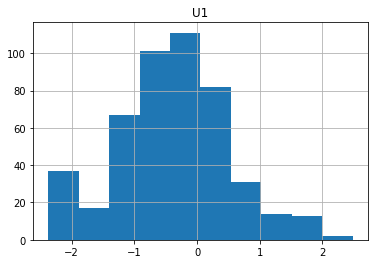

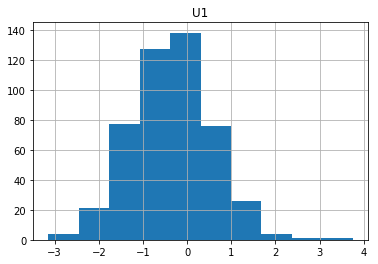

In [23]:
# First comparing control with matchted test units:

matched_treated.hist('U1'), control.hist('U1')

(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c67257ac8>]],
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c671ea550>]],
       dtype=object))

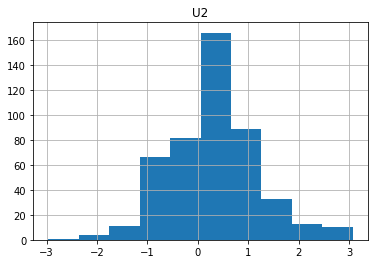

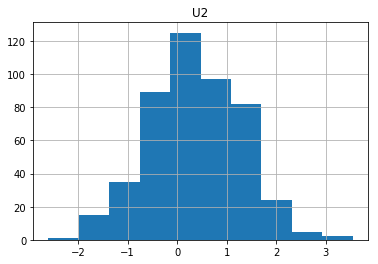

In [24]:
matched_treated.hist('U2'), control.hist('U2')

(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c6718f978>]],
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c67151358>]],
       dtype=object))

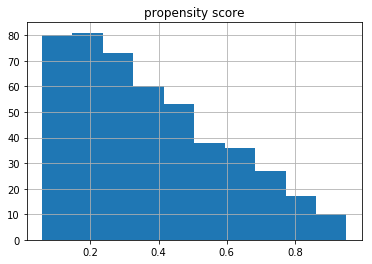

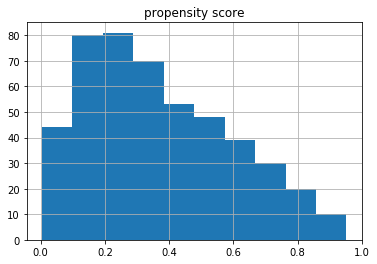

In [25]:
matched_treated.hist('propensity score'), control.hist('propensity score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c67034e10>]],
      dtype=object)

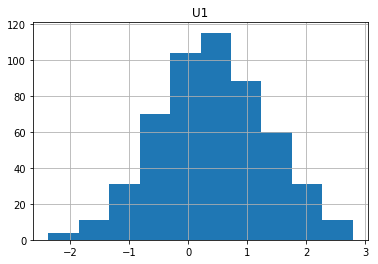

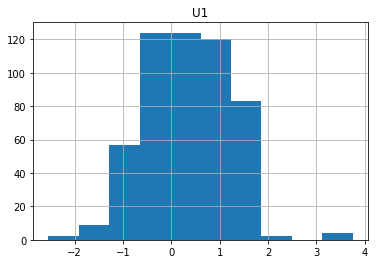

In [26]:
# And then test with matched control

treated.hist('U1'); matched_control.hist('U1')

(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ce3ba0a90>]],
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ce3a5ad30>]],
       dtype=object))

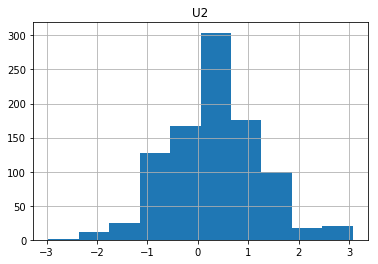

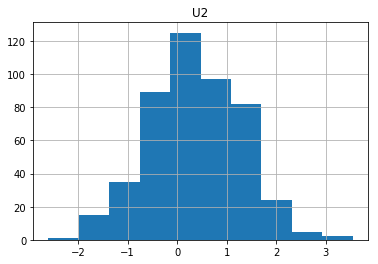

In [17]:
matched_treated.hist('U2'), control.hist('U2')

(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c6700eba8>]],
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c67076a58>]],
       dtype=object))

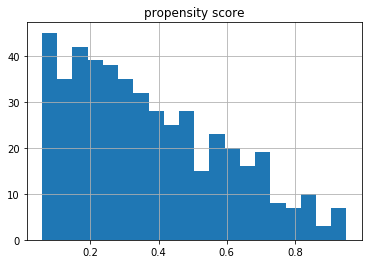

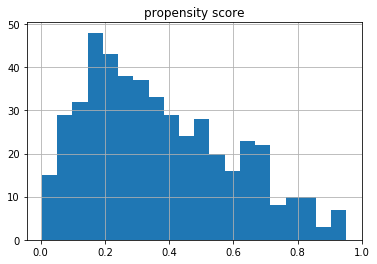

In [27]:
matched_treated.hist('propensity score', bins=20), control.hist('propensity score', bins=20)

Both look pretty good! Especially considering they're pretty opposite prior to matching:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ce38b1cc0>]],
      dtype=object)

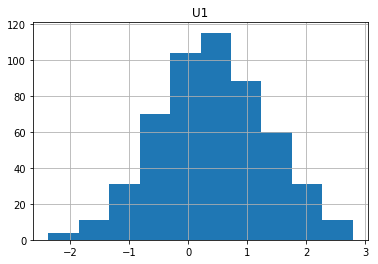

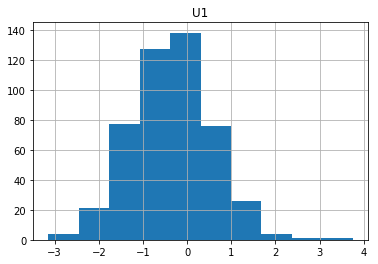

In [19]:
df[df.X == 1].hist('U1'); df[df.X == 0].hist('U1')

Does propensity score matching achieve balance on the propensity scores, $e(Z) = P(X=1|Z)$? A handy statistic is the score
\begin{equation}
s = \frac{E[e(Z)| X = 1] - E[e(Z)| X=0]}{\sqrt{\frac{1}{2}(Var(e(Z)|X=1) - Var(e(Z)|X=0))}}
\end{equation}


We can actually calculate this on $Z$ as well. Prior to matching, we get

In [29]:
matcher.assess_balance(df, 'X', {'U1': 'c', 
                                 'U2': 'c', 
                                 'propensity score': 'c'})

{'U1': 0.8252047412231942,
 'U2': -0.8124598935389282,
 'propensity score': 1.298224764172099}

In [30]:
matcher.assess_balance(treated.append(matched_control),  'X', {'U1': 'c', 'U2': 'c', 'propensity score': 'c'})

/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'U1': 0.11729965745675075,
 'U2': 0.07564323072390548,
 'propensity score': 0.0052138954632347636}

Balance has improved on the $Z$ variables, but we don't really care about that! They contribute oppositely to the propensity score, so can cancel each others' contributions to $P(X=1|Z)$. Balance on propensity scores is what we really care about.